In [1]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.ndimage import label, distance_transform_edt

In [2]:
def slic_superpixel_segmentation(image, n_segments=500, compactness=10):
    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)
    return segments

In [3]:
def quantize_superpixels(image, segments, n_colors=30):
    lab_image = rgb2lab(image)
    unique_segments = np.unique(segments)
    avg_colors = []

    for segment_value in unique_segments:
        mask = segments == segment_value
        avg_color = np.mean(lab_image[mask], axis=0)
        avg_colors.append(avg_color)

    avg_colors = np.array(avg_colors)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(avg_colors)
    quantized_colors = kmeans.cluster_centers_

    quantized_image = np.zeros_like(lab_image)
    quantized_indices = np.zeros(segments.shape, dtype=np.int32)
    for i, segment_value in enumerate(unique_segments):
        mask = segments == segment_value
        quantized_image[mask] = quantized_colors[kmeans.labels_[i]]
        quantized_indices[mask] = kmeans.labels_[i]

    quantized_image = lab2rgb(quantized_image)
    return (quantized_image * 255).astype(np.uint8), quantized_indices, quantized_colors

In [4]:
def label_regions_within_edges(quantized_indices, edges, min_segment_size=100, boundary_padding=5, extra_padding=5):
    # Create a white background image
    labeled_image = np.ones((quantized_indices.shape[0], quantized_indices.shape[1], 3), dtype=np.uint8) * 255
    height, width = quantized_indices.shape

    # Loop through each unique color index in the quantized image
    unique_colors = np.unique(quantized_indices)
    
    for color_index in unique_colors:
        # Create a mask for the current color region
        mask = quantized_indices == color_index
        
        # Label connected components in the mask
        labeled_mask, num_features = label(mask)
        
        for i in range(1, num_features + 1):
            # Find the coordinates of the current region
            region_mask = labeled_mask == i

            # Skip very small regions to avoid clutter
            if np.sum(region_mask) < min_segment_size:
                continue

            # Apply a distance transform to find the point farthest from the edges
            distance_transform = distance_transform_edt(region_mask)
            max_dist_idx = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
            final_x, final_y = max_dist_idx[1], max_dist_idx[0]

            # Determine an appropriate text size based on the region size
            region_area = np.sum(region_mask)
            font_scale = min(0.4, max(0.1, region_area / 1000))  # Dynamic font scale

            # Adjust final_x and final_y to add extra padding
            final_x = np.clip(final_x, boundary_padding + extra_padding, width - boundary_padding - extra_padding)
            final_y = np.clip(final_y, boundary_padding + extra_padding, height - boundary_padding - extra_padding)

            # Get text size to check bounding box
            text = str(color_index + 1)
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)[0]
            text_x = final_x - text_size[0] // 2
            text_y = final_y + text_size[1] // 2

            # Check if the bounding box of the text fits inside the region
            fits_inside = True
            for dx in range(-2, text_size[0] + 2):  # Check along the width of the text
                for dy in range(-text_size[1], 2):  # Check along the height of the text
                    check_x = text_x + dx
                    check_y = text_y + dy
                    if not (0 <= check_x < width and 0 <= check_y < height and region_mask[check_y, check_x]):
                        fits_inside = False
                        break
                if not fits_inside:
                    break

            if fits_inside:
                # Draw a small white rectangle behind the number to improve visibility
                cv2.rectangle(labeled_image, (text_x - 2, text_y - text_size[1] - 2), 
                              (text_x + text_size[0] + 2, text_y + 2), (255, 255, 255), -1)

                # Draw the label number in royal blue
                cv2.putText(labeled_image, text, (text_x, text_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 85), 1, cv2.LINE_AA)
            else:
                # If it doesn't fit, place the number at the centroid, even if it goes over the border
                text_x = final_x - text_size[0] // 2
                text_y = final_y + text_size[1] // 2

                # Draw a small white rectangle behind the number to improve visibility
                cv2.rectangle(labeled_image, (text_x - 2, text_y - text_size[1] - 2), 
                              (text_x + text_size[0] + 2, text_y + 2), (255, 255, 255), -1)

                # Draw the label number in royal blue
                cv2.putText(labeled_image, text, (text_x, text_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 85), 1, cv2.LINE_AA)

    # Add black edges to the labeled image
    labeled_image[edges == 0] = 0  # Set edge pixels to black

    return labeled_image


In [5]:
def create_paint_by_number_edges(quantized_indices):
    # Create an edge image by marking the boundaries between quantized color regions
    edges_image = np.zeros(quantized_indices.shape, dtype=np.uint8)
    
    # Check neighboring pixels to find boundaries
    for y in range(quantized_indices.shape[0] - 1):
        for x in range(quantized_indices.shape[1] - 1):
            if quantized_indices[y, x] != quantized_indices[y, x + 1] or quantized_indices[y, x] != quantized_indices[y + 1, x]:
                edges_image[y, x] = 255  # Set boundary pixel to white

    # Invert the edge image for better visibility (black on white)
    edges_image = cv2.bitwise_not(edges_image)
    
    return edges_image


In [6]:
def add_black_border(image, border_size=10):
    # Add a black border to the image
    bordered_image = cv2.copyMakeBorder(
        image,
        top=border_size,
        bottom=border_size,
        left=border_size,
        right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # Black color
    )
    return bordered_image

In [7]:
def display_color_palette(quantized_colors, colors_per_row=10):
    n_colors = len(quantized_colors)
    
    # Convert colors from LAB to RGB
    rgb_colors = lab2rgb(quantized_colors.reshape(1, n_colors, 3)).reshape(n_colors, 3)
    
    # Determine the number of rows needed
    n_rows = int(np.ceil(n_colors / colors_per_row))
    
    fig, ax = plt.subplots(n_rows, colors_per_row, figsize=(15, n_rows * 0.5))
    
    # Remove axis and set up a grid layout
    for row in range(n_rows):
        for col in range(colors_per_row):
            index = row * colors_per_row + col
            if index < n_colors:
                # Draw the color box with a horizontal aspect ratio
                ax[row, col].add_patch(plt.Rectangle((0, 0), 2, 1, color=rgb_colors[index]))  # Horizontal rectangle
                
                # Place the number to the right of the color box
                ax[row, col].text(2.2, 0.5, str(index + 1), ha='left', va='center', fontsize=12, color='black')
                
                ax[row, col].set_xlim(0, 3)  # Set x limits to fit color box and text
                ax[row, col].set_ylim(0, 1)
            else:
                # Hide unused subplots
                ax[row, col].axis('off')
            
            # Remove axes for each subplot
            ax[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


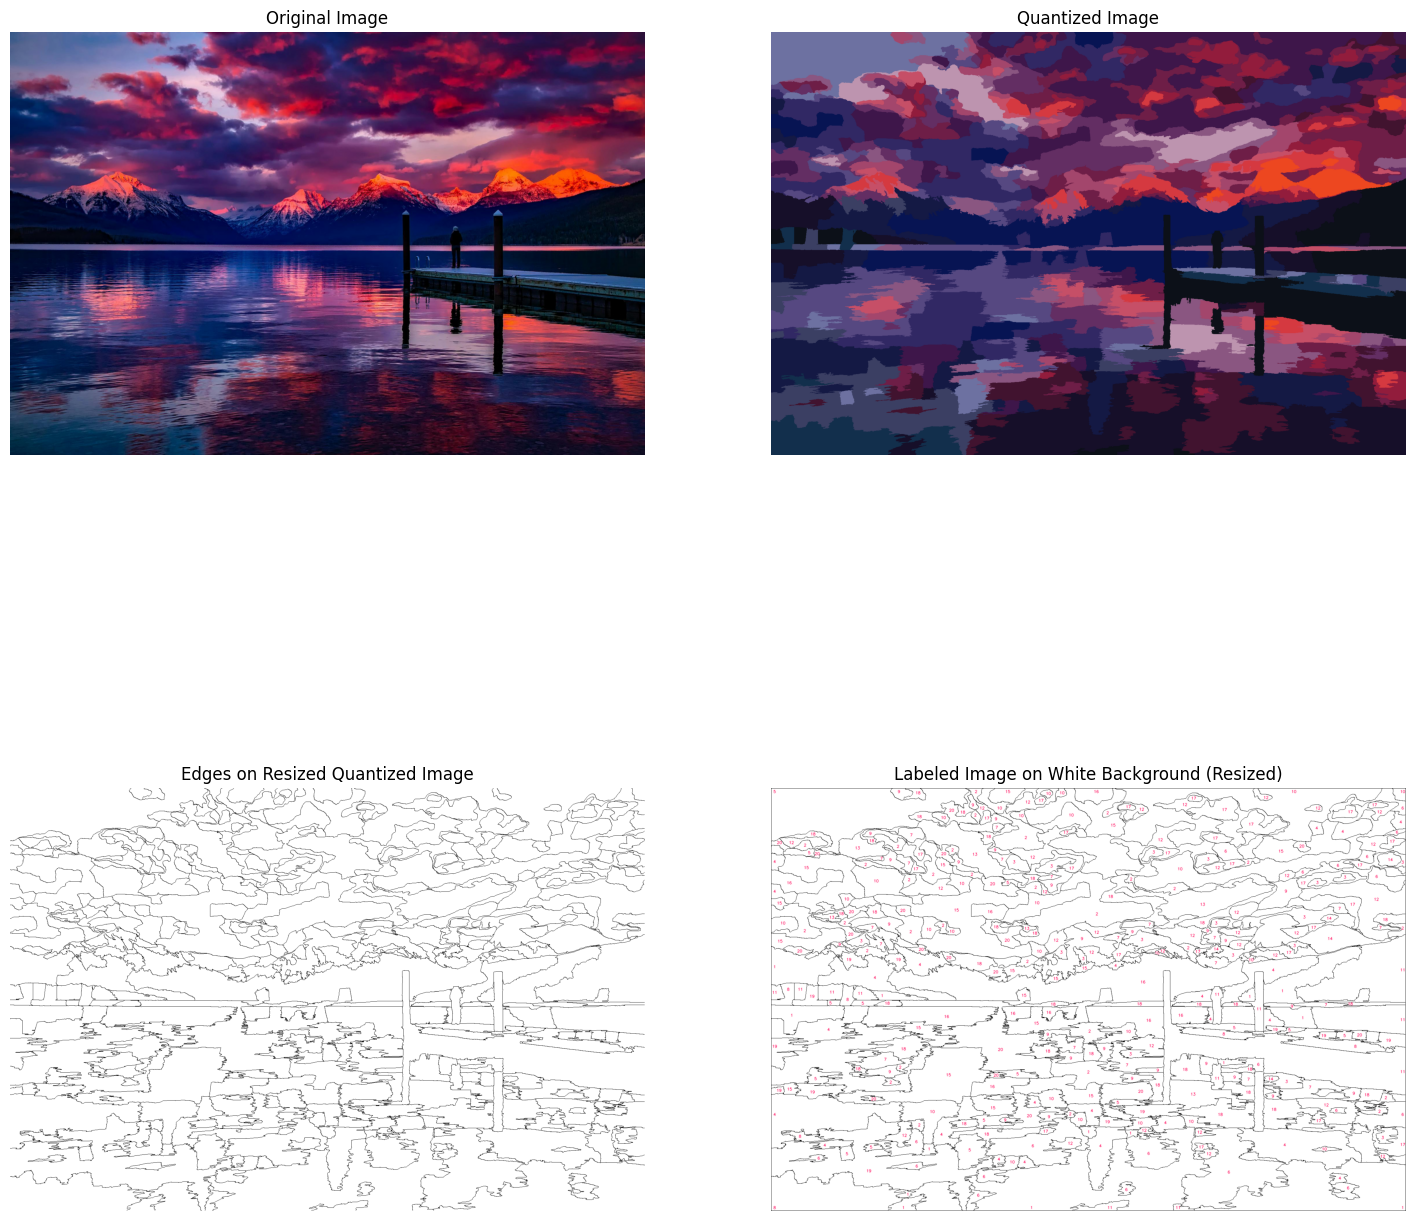

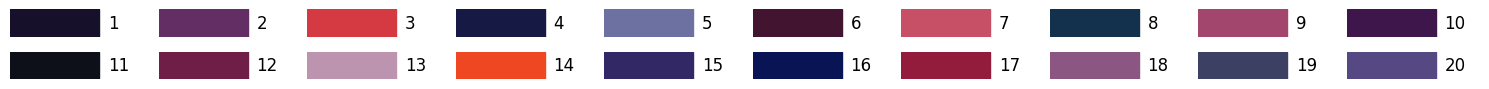

In [8]:
# Load the image
image_path = './example_images/scenery.jpg'
image = cv2.imread(image_path)

# Resize if necessary
height, width, _ = image.shape
max_dimension = 2000
if height > max_dimension or width > max_dimension:
    scaling_factor = max_dimension / max(height, width)
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    image = cv2.resize(image, (new_width, new_height))

# Convert image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply SLIC superpixel segmentation
n_segments = 2000
compactness = 10
segments = slic_superpixel_segmentation(image, n_segments=n_segments, compactness=compactness)

# Quantize superpixels to a limited color palette
n_colors = 20
quantized_image, quantized_indices, quantized_colors = quantize_superpixels(image, segments, n_colors=n_colors)

# Create edges and labeled image
edges = create_paint_by_number_edges(quantized_indices)
labeled_image_on_white = label_regions_within_edges(quantized_indices, edges)

# Add a black border around 'labeled_image_on_white'
labeled_image_on_white_with_border = add_black_border(labeled_image_on_white, border_size=1)


# Display images and color palette
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(quantized_image)
axs[0, 1].set_title('Quantized Image')
axs[0, 1].axis('off')

axs[1, 0].imshow(edges, cmap='gray')
axs[1, 0].set_title('Edges on Resized Quantized Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(labeled_image_on_white_with_border)
axs[1, 1].set_title('Labeled Image on White Background (Resized)')
axs[1, 1].axis('off')

plt.show()

# Display the color palette
display_color_palette(quantized_colors)


In [ ]:
# Save labeled_image_on_white as a PNG file
cv2.imwrite('labeled_scenery2.png', labeled_image_on_white)


In [16]:
# Save labeled_image_on_white as a PDF file using matplotlib
plt.imsave('labeled_image_on_white.pdf', labeled_image_on_white)
